In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from enum import *
import time

startInstantTime = time.time()

In [2]:
#Se controla por medio de estados la clasificacion de todas las muestras de una clase fijada
class EstadosClasificacion(Enum):
    estado1 = "Todas las muestras de la clase 1 están efectivamente en la clase 1"
    estado2 = "Todas las muestras de la clase 2 están efectivamente en la clase 2"
    estado3 = "Se tiene al menos una muestra en la clase equivocada"

def printColouredText(text, foregroundColor = (0, 0, 0), backgroundColor = (255, 255, 255)):
    return "\033[48;2;{};{};{}m\033[38;2;{};{};{}m{}\033[38;2;0;0;0m\033[48;2;255;255;255m".format(backgroundColor[0], backgroundColor[1], backgroundColor[2], foregroundColor[0], foregroundColor[1], foregroundColor[2], text)

#La distancia con signo (ignorando el valor absoluto involucrado en la formula de distancia de un punto a un hiperplano) permite saber la distancia ademas de si el punto se encuentra por encima o por debajo del hiperplano
def calcularDistanciaConSignoPuntoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoMuestra, numeroDimensiones):
    return (np.dot(listaCoeficientesCompletosHiperplanoSeparacion[0:numeroDimensiones], puntoMuestra) + listaCoeficientesCompletosHiperplanoSeparacion[numeroDimensiones]) / np.linalg.norm(listaCoeficientesCompletosHiperplanoSeparacion[0:numeroDimensiones])

def evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoMuestra, numeroDimensiones):
    return np.dot(listaCoeficientesCompletosHiperplanoSeparacion[0:numeroDimensiones], puntoMuestra) + listaCoeficientesCompletosHiperplanoSeparacion[numeroDimensiones]

def generarPuntosMuestra(numeroMuestrasClase1, numeroMuestrasClase2, nombreClase1, nombreClase2, listaCoeficientesCompletosHiperplanoSeparacion, minimoValorCoordenadasPuntos, maximoValorCoordenadasPuntos, numeroDimensiones, margenMinimoSeparacionEntreClases = 1.0):
    muestraPuntos = []
    muestraPuntosPorClases = {nombreClase1: [], nombreClase2: []}
    
    #Se generan los puntos de la primera clase (Se tienen como restricciones que esten a distancia del hiperplano mayor al margen y este por encima del hiperplano, ademas que el punto no se repita)
    for indice in range(numeroMuestrasClase1):
        puntoMuestraValido = False
        while puntoMuestraValido == False:
            puntoGenerado = list(np.random.uniform(low = minimoValorCoordenadasPuntos, high = maximoValorCoordenadasPuntos, size = numeroDimensiones))
            distanciaPuntoHiperplano = calcularDistanciaConSignoPuntoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoGenerado, numeroDimensiones)
            if distanciaPuntoHiperplano > margenMinimoSeparacionEntreClases and puntoGenerado not in muestraPuntosPorClases[nombreClase1]:
                muestraPuntos.append(puntoGenerado)
                muestraPuntosPorClases[nombreClase1].append(puntoGenerado)
                puntoMuestraValido = True
    
    #Se generan los puntos de la segunda clase (Se tienen como restricciones que esten a distancia del hiperplano mayor al margen y este por debajo del hiperplano, ademas que el punto no se repita)
    for indice in range(numeroMuestrasClase2):
        puntoMuestraValido = False
        while puntoMuestraValido == False:
            puntoGenerado = list(np.random.uniform(low = minimoValorCoordenadasPuntos, high = maximoValorCoordenadasPuntos, size = numeroDimensiones))
            distanciaPuntoHiperplano = calcularDistanciaConSignoPuntoAHiperplano(listaCoeficientesCompletosHiperplanoSeparacion, puntoGenerado, numeroDimensiones)
            if distanciaPuntoHiperplano < -margenMinimoSeparacionEntreClases and puntoGenerado not in muestraPuntosPorClases[nombreClase2]:
                muestraPuntos.append(puntoGenerado)
                muestraPuntosPorClases[nombreClase2].append(puntoGenerado)
                puntoMuestraValido = True
    return muestraPuntos, muestraPuntosPorClases

def verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClaseObjetivo, listaCoeficientesCompletosHiperplano, numeroDimensiones):
    clasePuntoActual = nombreClaseObjetivo
    clasePuntoAnterior = nombreClaseObjetivo
    for punto in muestraPuntosPorClases[nombreClaseObjetivo]:
        clasePuntoAnterior = clasePuntoActual
        valorPunto = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, punto, numeroDimensiones)
        if valorPunto == 0.0:
            return EstadosClasificacion.estado3
        elif np.sign(valorPunto) == 1.0:
            clasePuntoActual = nombreClase1
        else:
            clasePuntoActual = nombreClase2
        
        if clasePuntoActual != clasePuntoAnterior:
            return EstadosClasificacion.estado3
    
    if clasePuntoActual == nombreClase1:
        return EstadosClasificacion.estado1
    elif clasePuntoActual == nombreClase2:
        return EstadosClasificacion.estado2
    return EstadosClasificacion.estado3

def obtenerListasCoordenadasRespectivas(listaPuntos, numeroDimensiones):
    diccionarioPuntosPorCoordenadas = {}
    for indice in range(numeroDimensiones):
        diccionarioPuntosPorCoordenadas[indice] = []
        
    for puntoActual in listaPuntos:
        for indice in range(numeroDimensiones):
            coordenadaActual = puntoActual[indice]
            diccionarioPuntosPorCoordenadas[indice].append(coordenadaActual)
    return diccionarioPuntosPorCoordenadas

In [3]:
#Parametros de ejecucion del programa
tasaAprendizaje = 0.001
numeroDimensiones = 3
minimoValorCoordenadasPuntos = -20.0
maximoValorCoordenadasPuntos = 20.0
listaCoeficientesPrincipalesHiperplanoBase = [1.0] * numeroDimensiones
coeficienteInterceptoHiperplanoBase = -5.0
nombreClase1 = "Clase 1"
nombreClase2 = "Clase 2"
margenMinimoSeparacionEntreClases = 3.5
numeroMuestrasClase1 = 50
numeroMuestrasClase2 = 50
tiempoPausaAnimacion = 0.01

In [4]:
listaCoeficientesCompletosHiperplanoBase = listaCoeficientesPrincipalesHiperplanoBase + [coeficienteInterceptoHiperplanoBase]
listaPuntosMuestra, muestraPuntosPorClases = generarPuntosMuestra(numeroMuestrasClase1, numeroMuestrasClase2, nombreClase1, nombreClase2, listaCoeficientesCompletosHiperplanoBase, minimoValorCoordenadasPuntos, maximoValorCoordenadasPuntos, numeroDimensiones, margenMinimoSeparacionEntreClases = margenMinimoSeparacionEntreClases)

In [5]:
#Este bloque de codigo se puede comentar para que el hiperplano propuesto inicialmente separe perfectamente las muestras de las 2 clases y por lo tanto no se ejecuta el algoritmo del perceptron simple
listaCoeficientesCompletosHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))
while listaCoeficientesCompletosHiperplanoBase[0:numeroDimensiones] == [0] * numeroDimensiones:
    listaCoeficientesCompletosHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))

/tmp/ipykernel_7064/3260906296.py:79: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


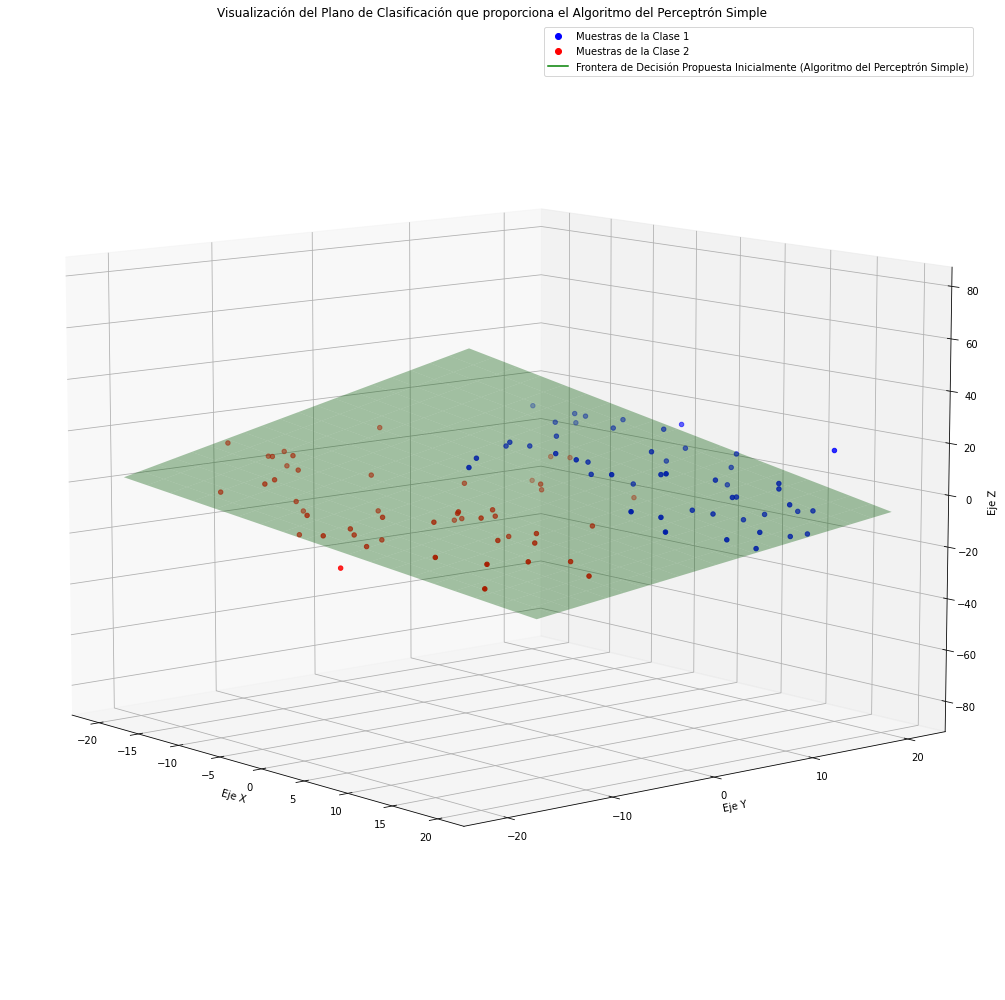

In [6]:
listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
valoresCoordenadasYPuntosClase1 = None
valoresCoordenadasYPuntosClase2 = None
valoresCoordenadasZPuntosClase1 = None
valoresCoordenadasZPuntosClase2 = None
minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
minimoEjeY = None
maximoEjeY = None
minimoEjeZ = None
maximoEjeZ = None

numeroMuestrasHiperplanoClasificacion = 20
if numeroDimensiones == 1:
    valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
    valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
    
    plt.figure(num = 1, figsize = (15, 3))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.axvline(x = -listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("")
    plt.gca().get_yaxis().set_visible(False)
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 2:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion

    plt.figure(num = 1, figsize = (15, 14))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'g-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)")
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
    valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
        listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] != 0.0:
        listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
    
    currentFigure = plt.figure(num = 1, figsize = (15, 14))
    ax = currentFigure.gca(projection = '3d')
    ax.view_init(elev = 10, azim = -40)
    ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
    etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
    ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
    etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'g', alpha = 0.35)
    etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlano], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)"], numpoints = 1)
    plt.tight_layout()
    plt.show()

In [7]:
#algoritmoPerceptronSimple(listaPuntosMuestra, muestraPuntosPorClases, listaCoeficientesCompletosHiperplanoBase, tasaAprendizaje, numeroDimensiones)

In [8]:
%matplotlib

listaCoeficientesCompletosHiperplano = listaCoeficientesCompletosHiperplanoBase
numeroPasos = 0
if numeroDimensiones == 1:
    plt.ion()
    while True:
        plt.clf()
        puntoMuestraSeleccionado = listaPuntosMuestra[np.random.randint(len(listaPuntosMuestra))]
        valorPuntoMuestraSeleccionado = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, puntoMuestraSeleccionado, numeroDimensiones)
        if not ((valorPuntoMuestraSeleccionado >= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]) or (valorPuntoMuestraSeleccionado <= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2])):
            if valorPuntoMuestraSeleccionado < 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] += tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] += tasaAprendizaje
            elif valorPuntoMuestraSeleccionado > 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] -= tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] -= tasaAprendizaje

        listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
        listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
        valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
        valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
        valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
        valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
        minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
        maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1

        plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
        plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
        plt.axvline(x = -listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
        plt.legend(loc = 'upper left')
        plt.xlabel("Eje X")
        plt.ylabel("")
        plt.gca().get_yaxis().set_visible(False)
        plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
        plt.grid(True)
        
        revisionClasificacion1 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase1, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        revisionClasificacion2 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase2, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        numeroPasos += 1
        if revisionClasificacion1.value == EstadosClasificacion.estado1.value and revisionClasificacion2.value == EstadosClasificacion.estado2.value:
            break
        
        plt.pause(tiempoPausaAnimacion)
        plt.ioff()
        plt.show()
elif numeroDimensiones == 2:
    plt.ion()
    while True:
        plt.clf()
        puntoMuestraSeleccionado = listaPuntosMuestra[np.random.randint(len(listaPuntosMuestra))]
        valorPuntoMuestraSeleccionado = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, puntoMuestraSeleccionado, numeroDimensiones)
        if not ((valorPuntoMuestraSeleccionado >= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]) or (valorPuntoMuestraSeleccionado <= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2])):
            if valorPuntoMuestraSeleccionado < 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] += tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] += tasaAprendizaje
            elif valorPuntoMuestraSeleccionado > 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] -= tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] -= tasaAprendizaje
        
        listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
        listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
        valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
        valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
        valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
        valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
        minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
        maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
        minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
        maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1

        listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
        listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
        if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
            listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
        elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
            listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion
        
        plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
        plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
        plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'g-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)")
        plt.legend(loc = 'upper left')
        plt.xlabel("Eje X")
        plt.ylabel("Eje Y")
        plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
        plt.grid(True)
        
        revisionClasificacion1 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase1, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        revisionClasificacion2 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase2, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        numeroPasos += 1
        if revisionClasificacion1.value == EstadosClasificacion.estado1.value and revisionClasificacion2.value == EstadosClasificacion.estado2.value:
            print("Fue(ron) necesario(s)", numeroPasos, "paso(s) para obtener una recta de clasificacion")
            #print("La recta de clasificacion que proporciona el algoritmo es " + str(w1) + "x + " + str(w2) + "y + " + str(b) + " = 0")
            break
            
        plt.pause(tiempoPausaAnimacion)
        plt.ioff()
        plt.show()
elif numeroDimensiones == 3:
    currentFigure = plt.figure(num = 2, figsize = (9, 8))
    ax = currentFigure.gca(projection = '3d')
    plt.ion()
    while True:
        ax.cla()
        puntoMuestraSeleccionado = listaPuntosMuestra[np.random.randint(len(listaPuntosMuestra))]
        valorPuntoMuestraSeleccionado = evaluarPuntoRespectoAHiperplano(listaCoeficientesCompletosHiperplano, puntoMuestraSeleccionado, numeroDimensiones)
        if not ((valorPuntoMuestraSeleccionado >= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]) or (valorPuntoMuestraSeleccionado <= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2])):
            if valorPuntoMuestraSeleccionado < 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] += tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] += tasaAprendizaje
            elif valorPuntoMuestraSeleccionado > 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2]:
                for indice in range(numeroDimensiones):
                    listaCoeficientesCompletosHiperplano[indice] -= tasaAprendizaje * puntoMuestraSeleccionado[indice]
                listaCoeficientesCompletosHiperplano[numeroDimensiones] -= tasaAprendizaje

        listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
        listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
        valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
        valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
        valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
        valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
        valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
        valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
        minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
        maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
        minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
        maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
        minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
        maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1
        
        listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
        listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
        listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
        if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
            listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
            listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
        elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
            listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
            listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]
        elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] != 0.0:
            listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
            listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
        
        ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
        etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
        ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
        etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
        ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'g', alpha = 0.35)
        etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
        ax.set_xlabel("Eje X")
        ax.set_ylabel("Eje Y")
        ax.set_zlabel("Eje Z")
        ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
        ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlano], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)"], numpoints = 1)
        plt.tight_layout()
        
        revisionClasificacion1 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase1, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        revisionClasificacion2 = verificarMuestrasClasificadasEnUnaSolaClase(muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase2, listaCoeficientesCompletosHiperplano, numeroDimensiones)
        numeroPasos += 1
        if revisionClasificacion1.value == EstadosClasificacion.estado1.value and revisionClasificacion2.value == EstadosClasificacion.estado2.value:
            print("Fue(ron) necesario(s)", numeroPasos, "paso(s) para obtener una recta de clasificacion")
            #print("La recta de clasificacion que proporciona el algoritmo es " + str(w1) + "x + " + str(w2) + "y + " + str(b) + " = 0")
            break
        
        plt.pause(tiempoPausaAnimacion)
    plt.ioff()
    plt.show()

Using matplotlib backend: TkAgg


/tmp/ipykernel_7064/485726143.py:105: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


Fue(ron) necesario(s) 1552 paso(s) para obtener una recta de clasificacion


/tmp/ipykernel_7064/4228246689.py:84: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


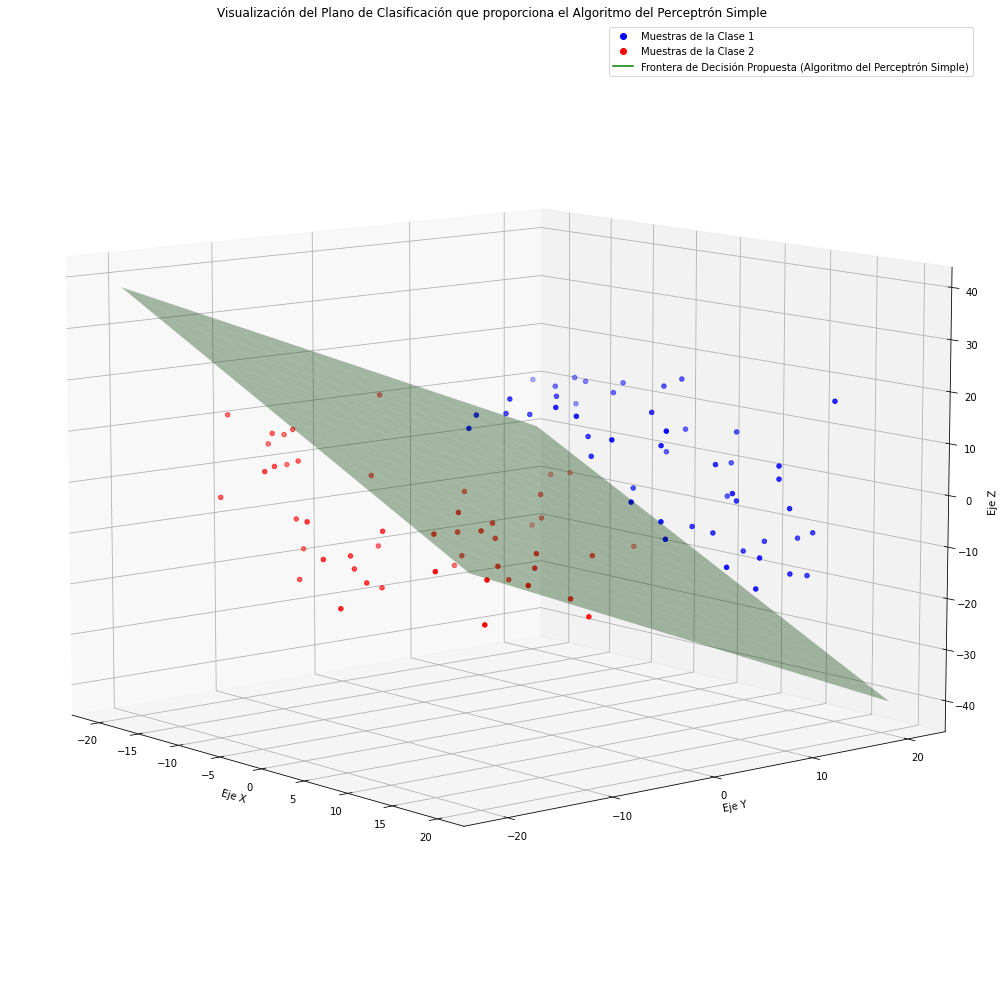

In [9]:
%matplotlib inline

listaCoeficientesCompletosHiperplano = listaCoeficientesCompletosHiperplanoBase
if numeroDimensiones == 1:
    listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
    listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
    valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
    valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
    valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
    valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
    minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
    maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
    
    plt.figure(num = 3, figsize = (15, 3))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.axvline(x = -listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("")
    plt.gca().get_yaxis().set_visible(False)
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 2:
    listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
    listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
    valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
    valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
    maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1

    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion
    
    plt.figure(num = 3, figsize = (15, 14))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'g-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)")
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
    listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
    valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
    valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
    valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
    minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
    maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
        listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesCompletosHiperplanoBase[numeroDimensiones]) / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 2]
    elif listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3] != 0.0:
        listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesCompletosHiperplanoBase[numeroDimensiones] / listaCoeficientesCompletosHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
    
    currentFigure = plt.figure(num = 3, figsize = (15, 14))
    ax = currentFigure.gca(projection = '3d')
    ax.view_init(elev = 10, azim = -40)
    ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
    etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
    ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
    etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'g', alpha = 0.35)
    etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlano], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)"], numpoints = 1)
    plt.tight_layout()
    plt.show()

In [10]:
colorTextoVerde = (35, 155, 86)
if numeroDimensiones == 1 or numeroDimensiones == 2:
    print("Fue(ron) necesario(s)", printColouredText(numeroPasos, colorTextoVerde), "paso(s) para obtener una recta de clasificación")
elif numeroDimensiones == 3:
    print("Fue(ron) necesario(s)", printColouredText(numeroPasos, colorTextoVerde), "paso(s) para obtener un plano de clasificación")
elif numeroDimensiones >= 4:
    print("Fue(ron) necesario(s)", printColouredText(numeroPasos, colorTextoVerde), "paso(s) para obtener un hiperplano de clasificación")

endInstantTime = time.time()
fullRunningTime = endInstantTime - startInstantTime
runningTimeInMinutes = int(fullRunningTime / 60)
runningTimeInSeconds = int(fullRunningTime % 60)
print("Tiempo de Ejecución: {} minutos y {} segundos".format(runningTimeInMinutes, runningTimeInSeconds))

Fue(ron) necesario(s) 1552 paso(s) para obtener un plano de clasificación
Tiempo de Ejecución: 1 minutos y 32 segundos
